# NLP Commodities Price Prediction

## Data Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [175]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from dotenv import load_dotenv
from huggingface_hub import InferenceClient
from keras import Sequential
from keras.src.callbacks import EarlyStopping
from keras.src.layers import Dense, Dropout, BatchNormalization
from keras.src.optimizers import Adam
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from textblob import TextBlob
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

import utils

In [3]:
load_dotenv()

model = os.getenv("model")
client = InferenceClient(model + "/v1/chat/completions", token=os.getenv("api_token"))

In [4]:
tqdm.pandas()

### Historical Data

In [27]:
hist_data = pd.read_csv('../data/historical data.csv')
hist_data

,Date,SPY_adj_close,SPY return,DIA_adj_close,DIA return,QQQ_adj_close,QQQ return,crude_oil,CPI,Fed Fund Rate,crude_oil_europe,natural_gas,crude_oil_europe_return,natural_gas_return,BTC-USD,^VIX,VXUS,VXUS_return,usd_index
0,2011-08-12,92.504018,0.006733,84.808441,0.013933,47.440430,0.008851,85.19,226.545,0.10,108.17,4.17,0.003246,0.027094,NaN,36.360001,30.239939,0.009585,74.610001
1,2011-08-15,94.461858,0.021165,86.319655,0.017819,48.140037,0.014747,87.88,226.545,0.10,108.89,4.05,0.006656,-0.028777,NaN,31.870001,30.961042,0.023846,73.839996
2,2011-08-16,93.655228,-0.008539,85.770806,-0.006358,47.732671,-0.008462,86.65,226.545,0.09,109.69,4.03,0.007347,-0.004938,NaN,32.849998,30.613850,-0.011214,74.010002
3,2011-08-17,93.717879,0.000669,85.906139,0.001578,47.449286,-0.005937,87.58,226.545,0.09,111.37,3.98,0.015316,-0.012407,NaN,31.580000,30.680618,0.002181,73.669998
4,2011-08-18,89.676897,-0.043119,82.755896,-0.036671,45.120215,-0.049085,82.38,226.545,0.09,108.36,3.98,-0.027027,0.000000,NaN,42.669998,29.318516,-0.044396,74.239998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2021-08-06,421.953285,0.001652,331.140931,0.004221,360.426156,-0.004382,68.26,273.567,0.10,71.02,4.21,-0.015525,-0.014052,42816.500000,16.150000,59.178802,-0.004713,92.800003
2513,2021-08-09,421.609993,-0.000814,330.256861,-0.002670,361.092071,0.001848,66.56,273.567,0.10,69.65,4.24,-0.019290,0.007126,46365.402344,16.719999,59.187843,0.000153,92.949997
2514,2021-08-10,422.134467,0.001244,331.742852,0.004500,359.241221,-0.005126,68.33,273.567,0.10,71.14,4.12,0.021393,-0.028302,45585.031250,16.790001,59.296318,0.001833,93.059998
2515,2021-08-11,423.183414,0.002485,333.821359,0.006265,358.624270,-0.001717,69.30,273.567,0.10,71.99,4.07,0.011948,-0.012136,45593.636719,16.170000,59.657936,0.006098,92.910004


In [28]:
# drop adj close columns
hist_data = hist_data.drop(
    columns=['SPY_adj_close', 'DIA_adj_close', 'QQQ_adj_close', 'crude_oil', 'crude_oil_europe', 'natural_gas',
             'BTC-USD', 'VXUS'])
hist_data

,Date,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_europe_return,natural_gas_return,^VIX,VXUS_return,usd_index
0,2011-08-12,0.006733,0.013933,0.008851,226.545,0.10,0.003246,0.027094,36.360001,0.009585,74.610001
1,2011-08-15,0.021165,0.017819,0.014747,226.545,0.10,0.006656,-0.028777,31.870001,0.023846,73.839996
2,2011-08-16,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,32.849998,-0.011214,74.010002
3,2011-08-17,0.000669,0.001578,-0.005937,226.545,0.09,0.015316,-0.012407,31.580000,0.002181,73.669998
4,2011-08-18,-0.043119,-0.036671,-0.049085,226.545,0.09,-0.027027,0.000000,42.669998,-0.044396,74.239998
...,...,...,...,...,...,...,...,...,...,...,...
2512,2021-08-06,0.001652,0.004221,-0.004382,273.567,0.10,-0.015525,-0.014052,16.150000,-0.004713,92.800003
2513,2021-08-09,-0.000814,-0.002670,0.001848,273.567,0.10,-0.019290,0.007126,16.719999,0.000153,92.949997
2514,2021-08-10,0.001244,0.004500,-0.005126,273.567,0.10,0.021393,-0.028302,16.790001,0.001833,93.059998
2515,2021-08-11,0.002485,0.006265,-0.001717,273.567,0.10,0.011948,-0.012136,16.170000,0.006098,92.910004


In [29]:
# calculate return for vix and usd_index
hist_data['vix_return'] = hist_data['^VIX'].pct_change()
hist_data['usd_index_return'] = hist_data['usd_index'].pct_change()
# drop adj close columns
hist_data = hist_data.drop(columns=['^VIX', 'usd_index'])
hist_data

/var/folders/8b/9mzlkxlx3zx9nmpy8prjpmm80000gn/T/ipykernel_42069/3510675308.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  hist_data['vix_return'] = hist_data['^VIX'].pct_change()
/var/folders/8b/9mzlkxlx3zx9nmpy8prjpmm80000gn/T/ipykernel_42069/3510675308.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  hist_data['usd_index_return'] = hist_data['usd_index'].pct_change()


,Date,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_europe_return,natural_gas_return,VXUS_return,vix_return,usd_index_return
0,2011-08-12,0.006733,0.013933,0.008851,226.545,0.10,0.003246,0.027094,0.009585,NaN,NaN
1,2011-08-15,0.021165,0.017819,0.014747,226.545,0.10,0.006656,-0.028777,0.023846,-0.123487,-0.010320
2,2011-08-16,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
3,2011-08-17,0.000669,0.001578,-0.005937,226.545,0.09,0.015316,-0.012407,0.002181,-0.038661,-0.004594
4,2011-08-18,-0.043119,-0.036671,-0.049085,226.545,0.09,-0.027027,0.000000,-0.044396,0.351172,0.007737
...,...,...,...,...,...,...,...,...,...,...,...
2512,2021-08-06,0.001652,0.004221,-0.004382,273.567,0.10,-0.015525,-0.014052,-0.004713,-0.065394,0.006071
2513,2021-08-09,-0.000814,-0.002670,0.001848,273.567,0.10,-0.019290,0.007126,0.000153,0.035294,0.001616
2514,2021-08-10,0.001244,0.004500,-0.005126,273.567,0.10,0.021393,-0.028302,0.001833,0.004187,0.001183
2515,2021-08-11,0.002485,0.006265,-0.001717,273.567,0.10,0.011948,-0.012136,0.006098,-0.036927,-0.001612


In [30]:
# drop rows with NaN
hist_data = hist_data.dropna()
hist_data

,Date,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_europe_return,natural_gas_return,VXUS_return,vix_return,usd_index_return
1,2011-08-15,0.021165,0.017819,0.014747,226.545,0.10,0.006656,-0.028777,0.023846,-0.123487,-0.010320
2,2011-08-16,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
3,2011-08-17,0.000669,0.001578,-0.005937,226.545,0.09,0.015316,-0.012407,0.002181,-0.038661,-0.004594
4,2011-08-18,-0.043119,-0.036671,-0.049085,226.545,0.09,-0.027027,0.000000,-0.044396,0.351172,0.007737
5,2011-08-19,-0.016330,-0.015817,-0.018057,226.545,0.09,0.009321,0.002513,-0.015941,0.008906,-0.003367
...,...,...,...,...,...,...,...,...,...,...,...
2511,2021-08-05,0.006333,0.007529,0.006343,273.567,0.10,0.016199,0.016667,0.002897,-0.038397,-0.000325
2512,2021-08-06,0.001652,0.004221,-0.004382,273.567,0.10,-0.015525,-0.014052,-0.004713,-0.065394,0.006071
2513,2021-08-09,-0.000814,-0.002670,0.001848,273.567,0.10,-0.019290,0.007126,0.000153,0.035294,0.001616
2514,2021-08-10,0.001244,0.004500,-0.005126,273.567,0.10,0.021393,-0.028302,0.001833,0.004187,0.001183


### Sentiment Data

In [31]:
sentiment_data = pd.read_csv('../data/Gold Dataset.csv')
sentiment_data

,Dates,URL,News
0,28-01-2016,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1..."
1,13-09-2017,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline
2,26-07-2016,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline
3,28-02-2018,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...
4,6/9/2017,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers..."
...,...,...,...
10565,7/1/2013,https://www.moneycontrol.com/news/business/mar...,gold seen falling from 3-week high this week
10566,27-09-2018,https://www.metalsdaily.com/link/284468/domini...,dominic frisby : now looks like a good time to...
10567,3/3/2017,https://www.thehindubusinessline.com/markets/g...,Gold heading for worst week since November on ...
10568,11/6/2008,http://www.marketwatch.com/story/august-gold-u...,august gold up $7.60 at $878.80 an ounce on nymex


In [32]:
# change date format to match historical data
sentiment_data['Dates'] = pd.to_datetime(sentiment_data['Dates'], format='mixed', errors='coerce').dt.strftime(
    '%Y-%m-%d')
sentiment_data

,Dates,URL,News
0,2016-01-28,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1..."
1,2017-09-13,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline
2,2016-07-26,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline
3,2018-02-28,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...
4,2017-06-09,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers..."
...,...,...,...
10565,2013-07-01,https://www.moneycontrol.com/news/business/mar...,gold seen falling from 3-week high this week
10566,2018-09-27,https://www.metalsdaily.com/link/284468/domini...,dominic frisby : now looks like a good time to...
10567,2017-03-03,https://www.thehindubusinessline.com/markets/g...,Gold heading for worst week since November on ...
10568,2008-11-06,http://www.marketwatch.com/story/august-gold-u...,august gold up $7.60 at $878.80 an ounce on nymex


In [33]:
# drop rows with NaN
sentiment_data = sentiment_data.dropna()
sentiment_data

,Dates,URL,News
0,2016-01-28,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1..."
1,2017-09-13,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline
2,2016-07-26,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline
3,2018-02-28,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...
4,2017-06-09,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers..."
...,...,...,...
10565,2013-07-01,https://www.moneycontrol.com/news/business/mar...,gold seen falling from 3-week high this week
10566,2018-09-27,https://www.metalsdaily.com/link/284468/domini...,dominic frisby : now looks like a good time to...
10567,2017-03-03,https://www.thehindubusinessline.com/markets/g...,Gold heading for worst week since November on ...
10568,2008-11-06,http://www.marketwatch.com/story/august-gold-u...,august gold up $7.60 at $878.80 an ounce on nymex


In [34]:
# sort data by date
sentiment_data = sentiment_data.sort_values('Dates')

In [35]:
# drop rows that have a date before 2011-08-01
sentiment_data = sentiment_data[sentiment_data['Dates'] >= '2011-08-01']
sentiment_data

,Dates,URL,News
75,2011-08-03,http://www.marketwatch.com/story/gold-declines...,gold futures close with a more than $7 loss
8464,2011-08-04,https://www.moneycontrol.com/news/business/mar...,"silver hits new high on global cues,gold moves up"
5015,2011-08-05,https://www.thehindubusinessline.com/markets/g...,"Gold may test resistance, fall"
4506,2011-08-06,http://www.marketwatch.com/story/go-for-the-go...,go for the gold?
1864,2011-08-08,https://www.moneycontrol.com/news/business/mar...,india gold extends gains to record high
...,...,...,...
7709,2019-04-01,https://www.metalsdaily.com/link/288180/etfs-g...,etfs : gld sees gold holdings drop nearly 50 t...
10303,2019-07-01,https://www.metalsdaily.com/link/288248/china-...,china 's gold reserves rise for 1st time in ov...
1421,2019-09-01,https://www.thehindubusinessline.com/markets/g...,Gold edges lower on improved risk appetite
4050,2019-09-01,https://www.thehindubusinessline.com/markets/g...,Gold up Rs 110 on jewellers' buying


In [36]:
# drop URL column
sentiment_data = sentiment_data.drop(columns=['URL'])

#### Calculate Sentiment Polarity and Subjectivity

In [37]:
# fix text spelling/grammar
sentiment_data['Polarity'] = sentiment_data['News'].progress_apply(lambda x: TextBlob(x).correct().sentiment.polarity)
sentiment_data['Subjectivity'] = sentiment_data['News'].progress_apply(
    lambda x: TextBlob(x).correct().sentiment.subjectivity)

sentiment_data

  0%|          | 0/7571 [00:00<?, ?it/s]

  0%|          | 0/7571 [00:00<?, ?it/s]

,Dates,News,Polarity,Subjectivity
75,2011-08-03,gold futures close with a more than $7 loss,0.250000,0.312500
8464,2011-08-04,"silver hits new high on global cues,gold moves up",0.098788,0.331515
5015,2011-08-05,"Gold may test resistance, fall",0.100000,0.200000
4506,2011-08-06,go for the gold?,0.000000,0.000000
1864,2011-08-08,india gold extends gains to record high,0.160000,0.540000
...,...,...,...,...
7709,2019-04-01,etfs : gld sees gold holdings drop nearly 50 t...,0.100000,0.300000
10303,2019-07-01,china 's gold reserves rise for 1st time in ov...,0.000000,0.000000
1421,2019-09-01,Gold edges lower on improved risk appetite,0.100000,0.200000
4050,2019-09-01,Gold up Rs 110 on jewellers' buying,0.100000,0.200000


#### Classify Past or Future Movement

In [62]:
# Function for classification
def classify_headline(headline):
    conversation = [
        {"role": "system", "content": "You are an assistant helping with text classification."},
        {
            "role": "user",
            "content": f"Classify each of the following texts into either 'Future' or 'Past' price movement. Respond only with 'Future' or 'Past' for this headline WITHOUT an explanation: {headline}"
        }
    ]
    response = client.chat_completion(
        messages=conversation,
        max_tokens=1,
        seed=42,
        temperature=0
    )
    return response.choices[0].message.content

In [63]:
# classify headlines
sentiment_data['Past/Future'] = sentiment_data['News'].progress_apply(classify_headline)

  0%|          | 0/7571 [00:00<?, ?it/s]

In [64]:
sentiment_data

,Dates,News,Polarity,Subjectivity,Subjective/Objective,Bullish/Bearish,Past/Future
75,2011-08-03,gold futures close with a more than $7 loss,0.250000,0.312500,Moderately Subjective,Moderately Bearish,Past
8464,2011-08-04,"silver hits new high on global cues,gold moves up",0.098788,0.331515,Moderately Subjective,Moderately Bullish,Past
5015,2011-08-05,"Gold may test resistance, fall",0.100000,0.200000,Moderately Subjective,Moderately Bearish,Past
4506,2011-08-06,go for the gold?,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Future
1864,2011-08-08,india gold extends gains to record high,0.160000,0.540000,Moderately Subjective,Moderately Bullish,Future
...,...,...,...,...,...,...,...
7709,2019-04-01,etfs : gld sees gold holdings drop nearly 50 t...,0.100000,0.300000,Moderately Subjective,Moderately Bearish,Past
10303,2019-07-01,china 's gold reserves rise for 1st time in ov...,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past
1421,2019-09-01,Gold edges lower on improved risk appetite,0.100000,0.200000,Moderately Subjective,Neutral,Past
4050,2019-09-01,Gold up Rs 110 on jewellers' buying,0.100000,0.200000,Moderately Subjective,Neutral,Past


#### Classify Short or Long Term

In [65]:
# Function for classification
def classify_headline(headline):
    conversation = [
        {"role": "system", "content": "You are an assistant helping with text classification."},
        {
            "role": "user",
            "content": f"Classify each of the following texts into either 'Short' or 'Long' term price movement. Respond only with 'Short' or 'Long' for this headline WITHOUT an explanation: {headline}"
        }
    ]
    response = client.chat_completion(
        messages=conversation,
        max_tokens=1,
        seed=42,
        temperature=0
    )
    return response.choices[0].message.content

In [66]:
# classify headlines
sentiment_data['Short/Long'] = sentiment_data['News'].progress_apply(classify_headline)

  0%|          | 0/7571 [00:00<?, ?it/s]

In [67]:
sentiment_data

,Dates,News,Polarity,Subjectivity,Subjective/Objective,Bullish/Bearish,Past/Future,Short/Long
75,2011-08-03,gold futures close with a more than $7 loss,0.250000,0.312500,Moderately Subjective,Moderately Bearish,Past,Long
8464,2011-08-04,"silver hits new high on global cues,gold moves up",0.098788,0.331515,Moderately Subjective,Moderately Bullish,Past,Long
5015,2011-08-05,"Gold may test resistance, fall",0.100000,0.200000,Moderately Subjective,Moderately Bearish,Past,Short
4506,2011-08-06,go for the gold?,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Future,Long
1864,2011-08-08,india gold extends gains to record high,0.160000,0.540000,Moderately Subjective,Moderately Bullish,Future,Long
...,...,...,...,...,...,...,...,...
7709,2019-04-01,etfs : gld sees gold holdings drop nearly 50 t...,0.100000,0.300000,Moderately Subjective,Moderately Bearish,Past,Long
10303,2019-07-01,china 's gold reserves rise for 1st time in ov...,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past,Long
1421,2019-09-01,Gold edges lower on improved risk appetite,0.100000,0.200000,Moderately Subjective,Neutral,Past,Short
4050,2019-09-01,Gold up Rs 110 on jewellers' buying,0.100000,0.200000,Moderately Subjective,Neutral,Past,Long


#### Classify Bullish or Bearish

In [59]:
# Function for classification
def classify_movement(headline):
    conversation = [
        {"role": "system", "content": "You are an assistant helping with text classification."},
        {
            "role": "user",
            "content": (
                f"Classify the following text into one of the following categories: "
                f"'Highly Bullish', 'Moderately Bullish', 'Neutral', 'Moderately Bearish', or 'Highly Bearish'. "
                f"Respond only with one of these categories and nothing else. No explanation, and no apostrophes/quotes.: {headline}"
            )
        }
    ]
    response = client.chat_completion(
        messages=conversation,
        max_tokens=5,  # Allow for longer labels
        seed=42,
        temperature=0
    )
    return response.choices[0].message.content

In [60]:
# classify headlines
sentiment_data['Bullish/Bearish'] = sentiment_data['News'].progress_apply(classify_movement)

  0%|          | 0/7571 [00:00<?, ?it/s]

In [61]:
sentiment_data

,Dates,News,Polarity,Subjectivity,Subjective/Objective,Bullish/Bearish
75,2011-08-03,gold futures close with a more than $7 loss,0.250000,0.312500,Moderately Subjective,Moderately Bearish
8464,2011-08-04,"silver hits new high on global cues,gold moves up",0.098788,0.331515,Moderately Subjective,Moderately Bullish
5015,2011-08-05,"Gold may test resistance, fall",0.100000,0.200000,Moderately Subjective,Moderately Bearish
4506,2011-08-06,go for the gold?,0.000000,0.000000,Moderately Subjective,Moderately Bullish
1864,2011-08-08,india gold extends gains to record high,0.160000,0.540000,Moderately Subjective,Moderately Bullish
...,...,...,...,...,...,...
7709,2019-04-01,etfs : gld sees gold holdings drop nearly 50 t...,0.100000,0.300000,Moderately Subjective,Moderately Bearish
10303,2019-07-01,china 's gold reserves rise for 1st time in ov...,0.000000,0.000000,Moderately Subjective,Moderately Bullish
1421,2019-09-01,Gold edges lower on improved risk appetite,0.100000,0.200000,Moderately Subjective,Neutral
4050,2019-09-01,Gold up Rs 110 on jewellers' buying,0.100000,0.200000,Moderately Subjective,Neutral


#### Classify Subjectivity

In [56]:
def classify_subjectivity(headline):
    conversation = [
        {"role": "system", "content": "You are an assistant helping with text classification."},
        {
            "role": "user",
            "content": (
                f"Classify the following text into one of the following categories: "
                f"'Highly Subjective', 'Moderately Subjective', or 'Objective'. "
                f"Respond only with one of these categories and nothing else. No explanation, and no apostrophes/quotes.: {headline}"
            )
        }
    ]
    response = client.chat_completion(
        messages=conversation,
        max_tokens=5,  # Allow for longer labels
        seed=42,
        temperature=0
    )
    return response.choices[0].message.content

In [57]:
# classify headlines
sentiment_data['Subjective/Objective'] = sentiment_data['News'].progress_apply(classify_subjectivity)

  0%|          | 0/7571 [00:00<?, ?it/s]

In [58]:
sentiment_data

,Dates,News,Polarity,Subjectivity,Subjective/Objective
75,2011-08-03,gold futures close with a more than $7 loss,0.250000,0.312500,Moderately Subjective
8464,2011-08-04,"silver hits new high on global cues,gold moves up",0.098788,0.331515,Moderately Subjective
5015,2011-08-05,"Gold may test resistance, fall",0.100000,0.200000,Moderately Subjective
4506,2011-08-06,go for the gold?,0.000000,0.000000,Moderately Subjective
1864,2011-08-08,india gold extends gains to record high,0.160000,0.540000,Moderately Subjective
...,...,...,...,...,...
7709,2019-04-01,etfs : gld sees gold holdings drop nearly 50 t...,0.100000,0.300000,Moderately Subjective
10303,2019-07-01,china 's gold reserves rise for 1st time in ov...,0.000000,0.000000,Moderately Subjective
1421,2019-09-01,Gold edges lower on improved risk appetite,0.100000,0.200000,Moderately Subjective
4050,2019-09-01,Gold up Rs 110 on jewellers' buying,0.100000,0.200000,Moderately Subjective


#### Calculate News Volume

In [68]:
# calculate news volume per day
sentiment_data['News Volume'] = sentiment_data['News'].progress_apply(lambda x: len(x.split()))
sentiment_data

  0%|          | 0/7571 [00:00<?, ?it/s]

,Dates,News,Polarity,Subjectivity,Subjective/Objective,Bullish/Bearish,Past/Future,Short/Long,News Volume
75,2011-08-03,gold futures close with a more than $7 loss,0.250000,0.312500,Moderately Subjective,Moderately Bearish,Past,Long,9
8464,2011-08-04,"silver hits new high on global cues,gold moves up",0.098788,0.331515,Moderately Subjective,Moderately Bullish,Past,Long,9
5015,2011-08-05,"Gold may test resistance, fall",0.100000,0.200000,Moderately Subjective,Moderately Bearish,Past,Short,5
4506,2011-08-06,go for the gold?,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Future,Long,4
1864,2011-08-08,india gold extends gains to record high,0.160000,0.540000,Moderately Subjective,Moderately Bullish,Future,Long,7
...,...,...,...,...,...,...,...,...,...
7709,2019-04-01,etfs : gld sees gold holdings drop nearly 50 t...,0.100000,0.300000,Moderately Subjective,Moderately Bearish,Past,Long,12
10303,2019-07-01,china 's gold reserves rise for 1st time in ov...,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past,Long,14
1421,2019-09-01,Gold edges lower on improved risk appetite,0.100000,0.200000,Moderately Subjective,Neutral,Past,Short,7
4050,2019-09-01,Gold up Rs 110 on jewellers' buying,0.100000,0.200000,Moderately Subjective,Neutral,Past,Long,7


#### Calculate Positive/Neutral/Negative Word Count

In [69]:
# calculate positive word count
sentiment_data['Positive Word Count'] = sentiment_data['News'].progress_apply(
    lambda x: len([word for word in x.split() if TextBlob(word).correct().sentiment.polarity > 0]))
# calculate neutral word count
sentiment_data['Neutral Word Count'] = sentiment_data['News'].progress_apply(
    lambda x: len([word for word in x.split() if TextBlob(word).correct().sentiment.polarity == 0]))
# calculate negative word count
sentiment_data['Negative Word Count'] = sentiment_data['News'].progress_apply(
    lambda x: len([word for word in x.split() if TextBlob(word).correct().sentiment.polarity < 0]))

sentiment_data

  0%|          | 0/7571 [00:00<?, ?it/s]

  0%|          | 0/7571 [00:00<?, ?it/s]

  0%|          | 0/7571 [00:00<?, ?it/s]

,Dates,News,Polarity,Subjectivity,Subjective/Objective,Bullish/Bearish,Past/Future,Short/Long,News Volume,Positive Word Count,Neutral Word Count,Negative Word Count
75,2011-08-03,gold futures close with a more than $7 loss,0.250000,0.312500,Moderately Subjective,Moderately Bearish,Past,Long,9,1,8,0
8464,2011-08-04,"silver hits new high on global cues,gold moves up",0.098788,0.331515,Moderately Subjective,Moderately Bullish,Past,Long,9,2,7,0
5015,2011-08-05,"Gold may test resistance, fall",0.100000,0.200000,Moderately Subjective,Moderately Bearish,Past,Short,5,1,4,0
4506,2011-08-06,go for the gold?,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Future,Long,4,0,4,0
1864,2011-08-08,india gold extends gains to record high,0.160000,0.540000,Moderately Subjective,Moderately Bullish,Future,Long,7,1,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7709,2019-04-01,etfs : gld sees gold holdings drop nearly 50 t...,0.100000,0.300000,Moderately Subjective,Moderately Bearish,Past,Long,12,2,10,0
10303,2019-07-01,china 's gold reserves rise for 1st time in ov...,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past,Long,14,0,14,0
1421,2019-09-01,Gold edges lower on improved risk appetite,0.100000,0.200000,Moderately Subjective,Neutral,Past,Short,7,1,6,0
4050,2019-09-01,Gold up Rs 110 on jewellers' buying,0.100000,0.200000,Moderately Subjective,Neutral,Past,Long,7,1,6,0


In [95]:
# merge historical data on sentiment data
df = pd.merge(sentiment_data, hist_data, how='left', left_on='Dates', right_on='Date')
df

,Dates,News,Polarity,Subjectivity,Subjective/Objective,Bullish/Bearish,Past/Future,Short/Long,News Volume,Positive Word Count,...,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_europe_return,natural_gas_return,VXUS_return,vix_return,usd_index_return
0,2011-08-03,gold futures close with a more than $7 loss,0.250000,0.312500,Moderately Subjective,Moderately Bearish,Past,Long,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-08-04,"silver hits new high on global cues,gold moves up",0.098788,0.331515,Moderately Subjective,Moderately Bullish,Past,Long,9,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-08-05,"Gold may test resistance, fall",0.100000,0.200000,Moderately Subjective,Moderately Bearish,Past,Short,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-08-06,go for the gold?,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Future,Long,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-08-08,india gold extends gains to record high,0.160000,0.540000,Moderately Subjective,Moderately Bullish,Future,Long,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7566,2019-04-01,etfs : gld sees gold holdings drop nearly 50 t...,0.100000,0.300000,Moderately Subjective,Moderately Bearish,Past,Long,12,2,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
7567,2019-07-01,china 's gold reserves rise for 1st time in ov...,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past,Long,14,0,...,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,-0.037190,0.005877,-0.067639,0.007386
7568,2019-09-01,Gold edges lower on improved risk appetite,0.100000,0.200000,Moderately Subjective,Neutral,Past,Short,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7569,2019-09-01,Gold up Rs 110 on jewellers' buying,0.100000,0.200000,Moderately Subjective,Neutral,Past,Long,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# drop rows with NaN
df = df.dropna()
df

,Dates,News,Polarity,Subjectivity,Subjective/Objective,Bullish/Bearish,Past/Future,Short/Long,News Volume,Positive Word Count,...,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_europe_return,natural_gas_return,VXUS_return,vix_return,usd_index_return
27,2011-08-15,"dec. gold rallies $13.60 to $1,756.20/oz in ny",0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past,Short,8,0,...,0.021165,0.017819,0.014747,226.545,0.10,0.006656,-0.028777,0.023846,-0.123487,-0.010320
28,2011-08-16,india gold rises over 1%; demand retreats,0.000000,0.000000,Moderately Subjective,Neutral,Past,Short,7,0,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
29,2011-08-16,gold futures close at a record level,0.000000,0.125000,Moderately Subjective,Moderately Bullish,Past,Long,7,0,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
30,2011-08-16,"dec. gold up $21.30 at $1,779.40/oz in ny",0.000000,0.000000,Objective,Moderately Bullish,Past,Short,8,0,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
31,2011-08-16,"dec. gold up $21.50, or 1.2%, at$1,779.50/oz i...",0.000000,0.000000,Objective,Moderately Bullish,Past,Short,9,0,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7564,2019-04-01,cpm group : politics expected to drive gold vo...,0.000000,0.350000,Moderately Subjective,Moderately Bullish,Past,Long,12,1,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
7565,2019-04-01,free : interactive gold charts here ...,0.400000,0.800000,Moderately Subjective,Neutral,Future,Short,7,1,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
7566,2019-04-01,etfs : gld sees gold holdings drop nearly 50 t...,0.100000,0.300000,Moderately Subjective,Moderately Bearish,Past,Long,12,2,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
7567,2019-07-01,china 's gold reserves rise for 1st time in ov...,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past,Long,14,0,...,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,-0.037190,0.005877,-0.067639,0.007386


### Gold Price

In [80]:
gold_price = pd.read_csv('../data/Gold Historical Data.csv')
gold_price

,Date,Close/Last,Volume,Open,High,Low
0,08/12/2021,1751.8,133990.0,1752.9,1759.6,1742.6
1,08/11/2021,1753.3,181306.0,1730.4,1756.7,1724.6
2,08/10/2021,1731.7,178253.0,1732.0,1739.4,1718.5
3,08/09/2021,1726.5,282388.0,1765.0,1765.7,1677.9
4,08/06/2021,1763.1,305778.0,1806.7,1807.0,1759.5
...,...,...,...,...,...,...
2554,08/18/2011,1822.0,197469.0,1818.0,1830.6,1786.8
2555,08/17/2011,1793.8,125321.0,1790.0,1797.6,1781.8
2556,08/16/2011,1785.0,148533.0,1780.8,1789.2,1763.6
2557,08/15/2011,1758.0,110191.0,1741.3,1767.8,1730.9


In [81]:
# change date format to match historical data
gold_price['Date'] = pd.to_datetime(gold_price['Date'], format='mixed', errors='coerce').dt.strftime('%Y-%m-%d')
gold_price

,Date,Close/Last,Volume,Open,High,Low
0,2021-08-12,1751.8,133990.0,1752.9,1759.6,1742.6
1,2021-08-11,1753.3,181306.0,1730.4,1756.7,1724.6
2,2021-08-10,1731.7,178253.0,1732.0,1739.4,1718.5
3,2021-08-09,1726.5,282388.0,1765.0,1765.7,1677.9
4,2021-08-06,1763.1,305778.0,1806.7,1807.0,1759.5
...,...,...,...,...,...,...
2554,2011-08-18,1822.0,197469.0,1818.0,1830.6,1786.8
2555,2011-08-17,1793.8,125321.0,1790.0,1797.6,1781.8
2556,2011-08-16,1785.0,148533.0,1780.8,1789.2,1763.6
2557,2011-08-15,1758.0,110191.0,1741.3,1767.8,1730.9


In [82]:
# create three columns, one for next day price, one for price in 3 days, and one for price in 5 days
gold_price['Next Day Price'] = gold_price['Close/Last'].shift(1)
gold_price['Price in 3 Days'] = gold_price['Close/Last'].shift(3)
gold_price['Price in 5 Days'] = gold_price['Close/Last'].shift(5)
gold_price

,Date,Close/Last,Volume,Open,High,Low,Next Day Price,Price in 3 Days,Price in 5 Days
0,2021-08-12,1751.8,133990.0,1752.9,1759.6,1742.6,NaN,NaN,NaN
1,2021-08-11,1753.3,181306.0,1730.4,1756.7,1724.6,1751.8,NaN,NaN
2,2021-08-10,1731.7,178253.0,1732.0,1739.4,1718.5,1753.3,NaN,NaN
3,2021-08-09,1726.5,282388.0,1765.0,1765.7,1677.9,1731.7,1751.8,NaN
4,2021-08-06,1763.1,305778.0,1806.7,1807.0,1759.5,1726.5,1753.3,NaN
...,...,...,...,...,...,...,...,...,...
2554,2011-08-18,1822.0,197469.0,1818.0,1830.6,1786.8,1852.2,1861.3,1763.2
2555,2011-08-17,1793.8,125321.0,1790.0,1797.6,1781.8,1822.0,1891.9,1757.3
2556,2011-08-16,1785.0,148533.0,1780.8,1789.2,1763.6,1793.8,1852.2,1861.3
2557,2011-08-15,1758.0,110191.0,1741.3,1767.8,1730.9,1785.0,1822.0,1891.9


In [97]:
# merge gold return with merged data
df = pd.merge(gold_price[['Date', 'Next Day Price', 'Price in 3 Days', 'Price in 5 Days']], df, how='right',
              left_on='Date', right_on='Dates')
df

,Date_x,Next Day Price,Price in 3 Days,Price in 5 Days,Dates,News,Polarity,Subjectivity,Subjective/Objective,Bullish/Bearish,...,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_europe_return,natural_gas_return,VXUS_return,vix_return,usd_index_return
0,2011-08-15,1785.0,1822.0,1891.9,2011-08-15,"dec. gold rallies $13.60 to $1,756.20/oz in ny",0.000000,0.000000,Moderately Subjective,Moderately Bullish,...,0.021165,0.017819,0.014747,226.545,0.10,0.006656,-0.028777,0.023846,-0.123487,-0.010320
1,2011-08-16,1793.8,1852.2,1861.3,2011-08-16,india gold rises over 1%; demand retreats,0.000000,0.000000,Moderately Subjective,Neutral,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
2,2011-08-16,1793.8,1852.2,1861.3,2011-08-16,gold futures close at a record level,0.000000,0.125000,Moderately Subjective,Moderately Bullish,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
3,2011-08-16,1793.8,1852.2,1861.3,2011-08-16,"dec. gold up $21.30 at $1,779.40/oz in ny",0.000000,0.000000,Objective,Moderately Bullish,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
4,2011-08-16,1793.8,1852.2,1861.3,2011-08-16,"dec. gold up $21.50, or 1.2%, at$1,779.50/oz i...",0.000000,0.000000,Objective,Moderately Bullish,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2019-04-01,1295.4,1294.3,1297.1,2019-04-01,cpm group : politics expected to drive gold vo...,0.000000,0.350000,Moderately Subjective,Moderately Bullish,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
6431,2019-04-01,1295.4,1294.3,1297.1,2019-04-01,free : interactive gold charts here ...,0.400000,0.800000,Moderately Subjective,Neutral,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
6432,2019-04-01,1295.4,1294.3,1297.1,2019-04-01,etfs : gld sees gold holdings drop nearly 50 t...,0.100000,0.300000,Moderately Subjective,Moderately Bearish,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
6433,2019-07-01,1408.0,1400.1,1400.5,2019-07-01,china 's gold reserves rise for 1st time in ov...,0.000000,0.000000,Moderately Subjective,Moderately Bullish,...,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,-0.037190,0.005877,-0.067639,0.007386


In [98]:
# drop Dates column and rename Date_x to Date
df = df.drop(columns=['Dates', 'Date_y'])
df = df.rename(columns={'Date_x': 'Date'})
df

,Date,Next Day Price,Price in 3 Days,Price in 5 Days,News,Polarity,Subjectivity,Subjective/Objective,Bullish/Bearish,Past/Future,...,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_europe_return,natural_gas_return,VXUS_return,vix_return,usd_index_return
0,2011-08-15,1785.0,1822.0,1891.9,"dec. gold rallies $13.60 to $1,756.20/oz in ny",0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past,...,0.021165,0.017819,0.014747,226.545,0.10,0.006656,-0.028777,0.023846,-0.123487,-0.010320
1,2011-08-16,1793.8,1852.2,1861.3,india gold rises over 1%; demand retreats,0.000000,0.000000,Moderately Subjective,Neutral,Past,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
2,2011-08-16,1793.8,1852.2,1861.3,gold futures close at a record level,0.000000,0.125000,Moderately Subjective,Moderately Bullish,Past,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
3,2011-08-16,1793.8,1852.2,1861.3,"dec. gold up $21.30 at $1,779.40/oz in ny",0.000000,0.000000,Objective,Moderately Bullish,Past,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
4,2011-08-16,1793.8,1852.2,1861.3,"dec. gold up $21.50, or 1.2%, at$1,779.50/oz i...",0.000000,0.000000,Objective,Moderately Bullish,Past,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2019-04-01,1295.4,1294.3,1297.1,cpm group : politics expected to drive gold vo...,0.000000,0.350000,Moderately Subjective,Moderately Bullish,Past,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
6431,2019-04-01,1295.4,1294.3,1297.1,free : interactive gold charts here ...,0.400000,0.800000,Moderately Subjective,Neutral,Future,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
6432,2019-04-01,1295.4,1294.3,1297.1,etfs : gld sees gold holdings drop nearly 50 t...,0.100000,0.300000,Moderately Subjective,Moderately Bearish,Past,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
6433,2019-07-01,1408.0,1400.1,1400.5,china 's gold reserves rise for 1st time in ov...,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past,...,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,-0.037190,0.005877,-0.067639,0.007386


In [133]:
# save to pickle
df.to_pickle('../data/gold_sentiment.pkl')

In [5]:
# load from pickle
df = pd.read_pickle('../data/gold_sentiment.pkl')

## Explanatory Data Analysis

In [6]:
# Describe data
df.describe()

,Next Day Price,Price in 3 Days,Price in 5 Days,Polarity,Subjectivity,News Volume,Positive Word Count,Neutral Word Count,Negative Word Count,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_europe_return,natural_gas_return,VXUS_return,vix_return,usd_index_return
count,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000,6387.000000
mean,1334.155253,1334.635557,1334.168624,0.032901,0.218942,9.259433,0.686238,8.336621,0.236574,0.000716,0.000752,0.000893,240.646181,0.715084,0.000640,0.000222,0.000398,0.003060,0.000019
std,169.926589,170.549180,170.217701,0.156141,0.212862,2.254311,0.791556,2.285600,0.462759,0.008653,0.008378,0.010679,7.633802,0.663642,0.018941,0.041143,0.010127,0.086785,0.004386
min,1049.600000,1049.600000,1049.600000,-1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,-0.043119,-0.045738,-0.049085,225.672000,0.040000,-0.077645,-0.378495,-0.077354,-0.259057,-0.017454
25%,1231.000000,1231.000000,1232.300000,0.000000,0.000000,8.000000,0.000000,7.000000,0.000000,-0.002667,-0.002677,-0.003639,234.149000,0.130000,-0.009358,-0.014652,-0.004298,-0.041026,-0.002691
50%,1282.700000,1281.600000,1280.200000,0.000000,0.200000,9.000000,1.000000,8.000000,0.000000,0.000649,0.000831,0.001210,241.428000,0.400000,0.000563,0.000000,0.000540,-0.004651,0.000000
75%,1339.200000,1341.300000,1344.100000,0.100000,0.325000,11.000000,1.000000,10.000000,0.000000,0.004811,0.004531,0.006422,246.663000,1.160000,0.010276,0.013559,0.005664,0.032740,0.002552
max,1891.900000,1891.900000,1891.900000,1.000000,1.000000,21.000000,5.000000,21.000000,3.000000,0.050525,0.048647,0.062439,257.208000,2.410000,0.104023,0.691057,0.052504,1.155979,0.020528


In [7]:
# drop any classification rows that are not 'Future' or 'Past'
df = df[(df['Past/Future'] == 'Future') | (df['Past/Future'] == 'Past')]

# drop any classification rows that are not 'Short' or 'Long'
df = df[(df['Short/Long'] == 'Short') | (df['Short/Long'] == 'Long')]

# drop any classification rows that are not 'Highly Bullish', 'Moderately Bullish', 'Neutral', 'Moderately Bearish', or 'Highly Bearish'
df = df[(df['Bullish/Bearish'] == 'Highly Bullish') | (df['Bullish/Bearish'] == 'Moderately Bullish') | (
        df['Bullish/Bearish'] == 'Neutral') | (df['Bullish/Bearish'] == 'Moderately Bearish') | (
                df['Bullish/Bearish'] == 'Highly Bearish')]
# drop any classification rows that are not 'Highly Subjective', 'Moderately Subjective', or 'Objective'
df = df[(df['Subjective/Objective'] == 'Highly Subjective') | (df['Subjective/Objective'] == 'Moderately Subjective') | (
        df['Subjective/Objective'] == 'Objective')]
df

,Date,Next Day Price,Price in 3 Days,Price in 5 Days,News,Polarity,Subjectivity,Subjective/Objective,Bullish/Bearish,Past/Future,...,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_europe_return,natural_gas_return,VXUS_return,vix_return,usd_index_return
0,2011-08-15,1785.0,1822.0,1891.9,"dec. gold rallies $13.60 to $1,756.20/oz in ny",0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past,...,0.021165,0.017819,0.014747,226.545,0.10,0.006656,-0.028777,0.023846,-0.123487,-0.010320
1,2011-08-16,1793.8,1852.2,1861.3,india gold rises over 1%; demand retreats,0.000000,0.000000,Moderately Subjective,Neutral,Past,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
2,2011-08-16,1793.8,1852.2,1861.3,gold futures close at a record level,0.000000,0.125000,Moderately Subjective,Moderately Bullish,Past,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
3,2011-08-16,1793.8,1852.2,1861.3,"dec. gold up $21.30 at $1,779.40/oz in ny",0.000000,0.000000,Objective,Moderately Bullish,Past,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
4,2011-08-16,1793.8,1852.2,1861.3,"dec. gold up $21.50, or 1.2%, at$1,779.50/oz i...",0.000000,0.000000,Objective,Moderately Bullish,Past,...,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2019-04-01,1295.4,1294.3,1297.1,cpm group : politics expected to drive gold vo...,0.000000,0.350000,Moderately Subjective,Moderately Bullish,Past,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
6431,2019-04-01,1295.4,1294.3,1297.1,free : interactive gold charts here ...,0.400000,0.800000,Moderately Subjective,Neutral,Future,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
6432,2019-04-01,1295.4,1294.3,1297.1,etfs : gld sees gold holdings drop nearly 50 t...,0.100000,0.300000,Moderately Subjective,Moderately Bearish,Past,...,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
6433,2019-07-01,1408.0,1400.1,1400.5,china 's gold reserves rise for 1st time in ov...,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past,...,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,-0.037190,0.005877,-0.067639,0.007386


### Feature Engineering

In [8]:
# Split data into features and target
X = df.drop(columns=['Date', 'News', 'Next Day Price', 'Price in 3 Days', 'Price in 5 Days'])
y_1day = df['Next Day Price']
y_3days = df['Price in 3 Days']
y_5days = df['Price in 5 Days']
X

,Polarity,Subjectivity,Subjective/Objective,Bullish/Bearish,Past/Future,Short/Long,News Volume,Positive Word Count,Neutral Word Count,Negative Word Count,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_europe_return,natural_gas_return,VXUS_return,vix_return,usd_index_return
0,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past,Short,8,0,8,0,0.021165,0.017819,0.014747,226.545,0.10,0.006656,-0.028777,0.023846,-0.123487,-0.010320
1,0.000000,0.000000,Moderately Subjective,Neutral,Past,Short,7,0,7,0,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
2,0.000000,0.125000,Moderately Subjective,Moderately Bullish,Past,Long,7,0,7,0,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
3,0.000000,0.000000,Objective,Moderately Bullish,Past,Short,8,0,8,0,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
4,0.000000,0.000000,Objective,Moderately Bullish,Past,Short,9,0,9,0,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,-0.004938,-0.011214,0.030750,0.002302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,0.000000,0.350000,Moderately Subjective,Moderately Bullish,Past,Long,12,1,10,1,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
6431,0.400000,0.800000,Moderately Subjective,Neutral,Future,Short,7,1,6,0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
6432,0.100000,0.300000,Moderately Subjective,Moderately Bearish,Past,Long,12,2,10,0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.000000,0.012909,-0.022611,-0.000308
6433,0.000000,0.000000,Moderately Subjective,Moderately Bullish,Past,Long,14,0,14,0,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,-0.037190,0.005877,-0.067639,0.007386


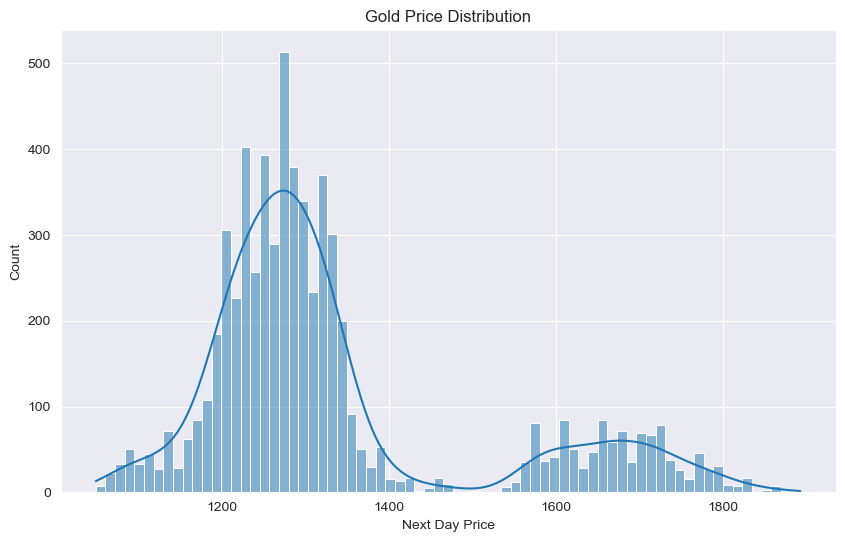

In [9]:
# plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(y_1day, kde=True)
plt.title('Gold Price Distribution')
plt.show()

#### Dummy Variables

In [10]:
# create dummy variables with any categorical columns
categorical = ['Past/Future', 'Short/Long', 'Bullish/Bearish', 'Subjective/Objective']
X = pd.get_dummies(X)
X

,Polarity,Subjectivity,News Volume,Positive Word Count,Neutral Word Count,Negative Word Count,SPY return,DIA return,QQQ return,CPI,...,Subjective/Objective_Objective,Bullish/Bearish_Highly Bearish,Bullish/Bearish_Highly Bullish,Bullish/Bearish_Moderately Bearish,Bullish/Bearish_Moderately Bullish,Bullish/Bearish_Neutral,Past/Future_Future,Past/Future_Past,Short/Long_Long,Short/Long_Short
0,0.000000,0.000000,8,0,8,0,0.021165,0.017819,0.014747,226.545,...,False,False,False,False,True,False,False,True,False,True
1,0.000000,0.000000,7,0,7,0,-0.008539,-0.006358,-0.008462,226.545,...,False,False,False,False,False,True,False,True,False,True
2,0.000000,0.125000,7,0,7,0,-0.008539,-0.006358,-0.008462,226.545,...,False,False,False,False,True,False,False,True,True,False
3,0.000000,0.000000,8,0,8,0,-0.008539,-0.006358,-0.008462,226.545,...,True,False,False,False,True,False,False,True,False,True
4,0.000000,0.000000,9,0,9,0,-0.008539,-0.006358,-0.008462,226.545,...,True,False,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,0.000000,0.350000,12,1,10,1,0.011859,0.012581,0.013247,255.548,...,False,False,False,False,True,False,False,True,True,False
6431,0.400000,0.800000,7,1,6,0,0.011859,0.012581,0.013247,255.548,...,False,False,False,False,False,True,True,False,False,True
6432,0.100000,0.300000,12,2,10,0,0.011859,0.012581,0.013247,255.548,...,False,False,False,True,False,False,False,True,True,False
6433,0.000000,0.000000,14,0,14,0,0.009078,0.004213,0.013495,256.571,...,False,False,False,False,True,False,False,True,True,False


In [11]:
# convert dummy variables to binary
X['Past/Future_Future'] = X['Past/Future_Future'].apply(lambda x: 1 if x == 1 else 0)
X['Short/Long_Short'] = X['Short/Long_Short'].apply(lambda x: 1 if x == 1 else 0)
X['Bullish/Bearish_Highly Bullish'] = X['Bullish/Bearish_Highly Bullish'].apply(lambda x: 1 if x == 1 else 0)
X['Bullish/Bearish_Moderately Bullish'] = X['Bullish/Bearish_Moderately Bullish'].apply(lambda x: 1 if x == 1 else 0)
X['Bullish/Bearish_Neutral'] = X['Bullish/Bearish_Neutral'].apply(lambda x: 1 if x == 1 else 0)
X['Bullish/Bearish_Moderately Bearish'] = X['Bullish/Bearish_Moderately Bearish'].apply(lambda x: 1 if x == 1 else 0)
X['Bullish/Bearish_Highly Bearish'] = X['Bullish/Bearish_Highly Bearish'].apply(lambda x: 1 if x == 1 else 0)
X['Subjective/Objective_Highly Subjective'] = X['Subjective/Objective_Highly Subjective'].apply(lambda x: 1 if x == 1 else 0)
X['Subjective/Objective_Moderately Subjective'] = X['Subjective/Objective_Moderately Subjective'].apply(
    lambda x: 1 if x == 1 else 0)
X['Subjective/Objective_Objective'] = X['Subjective/Objective_Objective'].apply(lambda x: 1 if x == 1 else 0)
X

,Polarity,Subjectivity,News Volume,Positive Word Count,Neutral Word Count,Negative Word Count,SPY return,DIA return,QQQ return,CPI,...,Subjective/Objective_Objective,Bullish/Bearish_Highly Bearish,Bullish/Bearish_Highly Bullish,Bullish/Bearish_Moderately Bearish,Bullish/Bearish_Moderately Bullish,Bullish/Bearish_Neutral,Past/Future_Future,Past/Future_Past,Short/Long_Long,Short/Long_Short
0,0.000000,0.000000,8,0,8,0,0.021165,0.017819,0.014747,226.545,...,0,0,0,0,1,0,0,True,False,1
1,0.000000,0.000000,7,0,7,0,-0.008539,-0.006358,-0.008462,226.545,...,0,0,0,0,0,1,0,True,False,1
2,0.000000,0.125000,7,0,7,0,-0.008539,-0.006358,-0.008462,226.545,...,0,0,0,0,1,0,0,True,True,0
3,0.000000,0.000000,8,0,8,0,-0.008539,-0.006358,-0.008462,226.545,...,1,0,0,0,1,0,0,True,False,1
4,0.000000,0.000000,9,0,9,0,-0.008539,-0.006358,-0.008462,226.545,...,1,0,0,0,1,0,0,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,0.000000,0.350000,12,1,10,1,0.011859,0.012581,0.013247,255.548,...,0,0,0,0,1,0,0,True,True,0
6431,0.400000,0.800000,7,1,6,0,0.011859,0.012581,0.013247,255.548,...,0,0,0,0,0,1,1,False,False,1
6432,0.100000,0.300000,12,2,10,0,0.011859,0.012581,0.013247,255.548,...,0,0,0,1,0,0,0,True,True,0
6433,0.000000,0.000000,14,0,14,0,0.009078,0.004213,0.013495,256.571,...,0,0,0,0,1,0,0,True,True,0


In [12]:
# drop Past/Future_Past and Short/Long_Long
X = X.drop(columns=['Past/Future_Past', 'Short/Long_Long'])
X

,Polarity,Subjectivity,News Volume,Positive Word Count,Neutral Word Count,Negative Word Count,SPY return,DIA return,QQQ return,CPI,...,Subjective/Objective_Highly Subjective,Subjective/Objective_Moderately Subjective,Subjective/Objective_Objective,Bullish/Bearish_Highly Bearish,Bullish/Bearish_Highly Bullish,Bullish/Bearish_Moderately Bearish,Bullish/Bearish_Moderately Bullish,Bullish/Bearish_Neutral,Past/Future_Future,Short/Long_Short
0,0.000000,0.000000,8,0,8,0,0.021165,0.017819,0.014747,226.545,...,0,1,0,0,0,0,1,0,0,1
1,0.000000,0.000000,7,0,7,0,-0.008539,-0.006358,-0.008462,226.545,...,0,1,0,0,0,0,0,1,0,1
2,0.000000,0.125000,7,0,7,0,-0.008539,-0.006358,-0.008462,226.545,...,0,1,0,0,0,0,1,0,0,0
3,0.000000,0.000000,8,0,8,0,-0.008539,-0.006358,-0.008462,226.545,...,0,0,1,0,0,0,1,0,0,1
4,0.000000,0.000000,9,0,9,0,-0.008539,-0.006358,-0.008462,226.545,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,0.000000,0.350000,12,1,10,1,0.011859,0.012581,0.013247,255.548,...,0,1,0,0,0,0,1,0,0,0
6431,0.400000,0.800000,7,1,6,0,0.011859,0.012581,0.013247,255.548,...,0,1,0,0,0,0,0,1,1,1
6432,0.100000,0.300000,12,2,10,0,0.011859,0.012581,0.013247,255.548,...,0,1,0,0,0,1,0,0,0,0
6433,0.000000,0.000000,14,0,14,0,0.009078,0.004213,0.013495,256.571,...,0,1,0,0,0,0,1,0,0,0


#### Remove Highly Correlated Features

In [13]:
X_vif = utils.calculate_vif(X, correlation_threshold=1)
X_vif

Removing high VIF and correlated variables:   0%|          | 0/26 [00:00<?, ?it/s]

Removed variable: SPY return with VIF: 38.40
Removed variable: CPI with VIF: 5.77
Removed variable: DIA return with VIF: 5.47
Removed variables with high VIF:
SPY return: 38.40
CPI: 5.77
DIA return: 5.47


,Polarity,Subjectivity,News Volume,Positive Word Count,Neutral Word Count,Negative Word Count,QQQ return,Fed Fund Rate,crude_oil_europe_return,natural_gas_return,...,Subjective/Objective_Highly Subjective,Subjective/Objective_Moderately Subjective,Subjective/Objective_Objective,Bullish/Bearish_Highly Bearish,Bullish/Bearish_Highly Bullish,Bullish/Bearish_Moderately Bearish,Bullish/Bearish_Moderately Bullish,Bullish/Bearish_Neutral,Past/Future_Future,Short/Long_Short
0,0.000000,0.000000,8,0,8,0,0.014747,0.10,0.006656,-0.028777,...,0,1,0,0,0,0,1,0,0,1
1,0.000000,0.000000,7,0,7,0,-0.008462,0.09,0.007347,-0.004938,...,0,1,0,0,0,0,0,1,0,1
2,0.000000,0.125000,7,0,7,0,-0.008462,0.09,0.007347,-0.004938,...,0,1,0,0,0,0,1,0,0,0
3,0.000000,0.000000,8,0,8,0,-0.008462,0.09,0.007347,-0.004938,...,0,0,1,0,0,0,1,0,0,1
4,0.000000,0.000000,9,0,9,0,-0.008462,0.09,0.007347,-0.004938,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,0.000000,0.350000,12,1,10,1,0.013247,2.41,0.016929,0.000000,...,0,1,0,0,0,0,1,0,0,0
6431,0.400000,0.800000,7,1,6,0,0.013247,2.41,0.016929,0.000000,...,0,1,0,0,0,0,0,1,1,1
6432,0.100000,0.300000,12,2,10,0,0.013247,2.41,0.016929,0.000000,...,0,1,0,0,0,1,0,0,0,0
6433,0.000000,0.000000,14,0,14,0,0.013495,2.39,-0.035841,-0.037190,...,0,1,0,0,0,0,1,0,0,0


#### Split Data

In [136]:
# Split the data once
X_train, X_test, y_train_1day, y_test_1day = train_test_split(X_vif, y_1day, test_size=0.2, random_state=42)

# Use the same train/test indices for the other target variables
y_train_3days = y_3days.loc[y_train_1day.index]
y_test_3days = y_3days.loc[y_test_1day.index]

y_train_5days = y_5days.loc[y_train_1day.index]
y_test_5days = y_5days.loc[y_test_1day.index]

#### Feature Scaling

In [137]:
# scale the features
scaler = StandardScaler()

# scale all but 10 dummy variables
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled.iloc[:, :-10] = scaler.fit_transform(X_train.iloc[:, :-10])
X_test_scaled.iloc[:, :-10] = scaler.transform(X_test.iloc[:, :-10])
X_train_scaled

/var/folders/8b/9mzlkxlx3zx9nmpy8prjpmm80000gn/T/ipykernel_52874/4117548294.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.55301951 -1.44178224  0.78012457 ...  3.00203138  0.33574321
 -0.55301951]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train_scaled.iloc[:, :-10] = scaler.fit_transform(X_train.iloc[:, :-10])
/var/folders/8b/9mzlkxlx3zx9nmpy8prjpmm80000gn/T/ipykernel_52874/4117548294.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.87228755 -0.87228755  0.39484839 ... -0.87228755  0.39484839
 -0.87228755]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train_scaled.iloc[:, :-10] = scaler.fit_transform(X_train.iloc[:, :-10])
/var/folders/8b/9mzlkxlx3zx9nmpy8prjpmm80000gn/T/ipykernel_52874/4117548294.py:7: FutureWarning: Setting an item

,Polarity,Subjectivity,News Volume,Positive Word Count,Neutral Word Count,Negative Word Count,QQQ return,Fed Fund Rate,crude_oil_europe_return,natural_gas_return,...,Subjective/Objective_Highly Subjective,Subjective/Objective_Moderately Subjective,Subjective/Objective_Objective,Bullish/Bearish_Highly Bearish,Bullish/Bearish_Highly Bullish,Bullish/Bearish_Moderately Bearish,Bullish/Bearish_Moderately Bullish,Bullish/Bearish_Neutral,Past/Future_Future,Short/Long_Short
3122,-0.210509,-1.033218,-0.553020,-0.872288,-0.140217,-0.508911,1.602921,-0.476305,-0.632069,0.938162,...,0,1,0,0,0,1,0,0,0,0
4637,-0.210509,-1.033218,-1.441782,-0.872288,-1.014908,-0.508911,-0.892857,0.664472,0.337891,-0.341709,...,0,0,1,0,0,0,1,0,0,1
6066,0.672586,1.114918,0.780125,0.394848,0.734473,-0.508911,-1.431550,1.805249,0.196550,0.343778,...,0,1,0,0,0,0,1,0,0,1
473,-0.210509,-1.033218,-1.441782,-0.872288,-1.014908,-0.508911,-0.500724,-0.926612,-0.792016,0.000447,...,0,0,1,0,0,1,0,0,0,1
3434,0.113292,-0.265259,-0.553020,0.394848,-0.577563,-0.508911,1.102909,-0.461295,-0.725029,0.347354,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,-0.210509,-1.033218,-0.553020,-0.872288,-0.140217,-0.508911,0.092012,-0.086039,-0.076772,-0.867492,...,0,1,0,0,0,0,0,1,0,0
5222,0.868830,1.329732,-0.108638,0.394848,-0.140217,-0.508911,0.985214,1.039727,0.035570,-0.835226,...,0,1,0,0,0,0,0,1,0,0
5257,-0.210509,-1.033218,3.002031,-0.872288,3.358543,-0.508911,-0.068184,1.054738,1.109674,0.746039,...,0,1,0,0,0,0,0,1,0,0
5424,-0.655736,0.089183,0.335743,0.394848,-0.140217,1.652375,-0.346967,1.054738,0.066775,0.383241,...,0,1,0,0,0,1,0,0,0,0


## Model Building

### Scoring and Cross-Validation

In [138]:
# Define a custom scorer
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [139]:
# Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

### Linear Regression

#### 1 Day Prediction

In [140]:
# use sklearn to fit a linear regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_1day)
y_pred_lr_train = lr.predict(X_train_scaled)
y_pred_lr = lr.predict(X_test_scaled)

# calculate the mean mae using the predictions
print(mean_absolute_error(y_test_1day, y_pred_lr))

# calculate the mean rmse using the predictions
print(root_mean_squared_error(y_test_1day, y_pred_lr))

114.26376173708923
154.2392309719504


#### 3 Day Prediction

In [141]:
# use sklearn to fit a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train_3days)
y_pred_lr_train = lr.predict(X_train)
y_pred_lr = lr.predict(X_test)

# calculate the mean mae using the predictions
print(mean_absolute_error(y_test_3days, y_pred_lr))

# calculate the mean rmse using the predictions
print(root_mean_squared_error(y_test_3days, y_pred_lr))

114.01353056762885
153.65415218564564


#### 5 Day Prediction

In [142]:
# use sklearn to fit a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train_5days)
y_pred_lr_train = lr.predict(X_train)
y_pred_lr = lr.predict(X_test)

# calculate the mean mae using the predictions
print(mean_absolute_error(y_test_5days, y_pred_lr))

# calculate the mean rmse using the predictions
print(root_mean_squared_error(y_test_5days, y_pred_lr))

113.70363708400578
152.74843593160728


In [143]:
y_train = y_train_3days
y_test = y_test_3days

In [144]:
# add a constant to the features
X_ols = sm.add_constant(X_train)
y_train_ols = y_train.copy()

# fit the model
ols = sm.OLS(y_train_ols, X_ols).fit()

# print the summary
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:        Price in 3 Days   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     54.91
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          2.60e-198
Time:                        23:22:31   Log-Likelihood:                -32980.
No. Observations:                5109   AIC:                         6.600e+04
Df Residuals:                    5088   BIC:                         6.614e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [145]:
# robust standard errors
robust_ols = ols.get_robustcov_results(cov_type='HC3')
print(robust_ols.summary())

                            OLS Regression Results                            
Dep. Variable:        Price in 3 Days   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                 3.799e+17
Date:                Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:22:35   Log-Likelihood:                -32980.
No. Observations:                5109   AIC:                         6.600e+04
Df Residuals:                    5088   BIC:                         6.614e+04
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 1
  warnings.warn('covariance of constraints does not have full '


### Random Forest

In [146]:
# create a random forest model
rf_model = RandomForestRegressor(random_state=42)

# evaluate the model
rf_model.fit(X_train, y_train)
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf = rf_model.predict(X_test)

# calculate the mean mae using the predictions
mean_absolute_error(y_test, y_pred_rf)

30.89074413145556

#### Hyperparameter Tuning

In [149]:
param_distributions_rf = {
    'n_estimators': randint(100, 1000),  # Number of trees (100 to 1000)
    'max_depth': randint(1, 10),  # Depth of trees (1 to 10)
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required in a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for best split
    'bootstrap': [True, False],  # Whether to use bootstrapping
}

In [150]:
# create a random search object
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions_rf,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x343d8a2a0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x343d8b740>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x343d8a1e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x343d8a270>},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                   verbose=2)

In [151]:
# Print the best parameters and score
print("Best Parameters: ", rf_random_search.best_params_)
print("Best Score: ", rf_random_search.best_score_)

Best Parameters:  {'bootstrap': True, 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 340}
Best Score:  -52.19037834729863


In [152]:
# Evaluate the model
y_pred_rf_tuned_train = rf_random_search.predict(X_train)
y_pred_rf_tuned = rf_random_search.predict(X_test)
mean_absolute_error(y_test, y_pred_rf_tuned)

49.79520926210308

### AdaBoost

In [153]:
# create an AdaBoost model
# create a base model
base_model = DecisionTreeRegressor(random_state=42)
ada_model = AdaBoostRegressor(base_model, random_state=42)

# evaluate the model
ada_model.fit(X_train, y_train)
y_pred_ada_train = ada_model.predict(X_train)
y_pred_ada = ada_model.predict(X_test)

# calculate the mean mae using the predictions
mean_absolute_error(y_test, y_pred_ada)

14.039906103286391

#### Hyperparameter Tuning

In [154]:
param_distributions_ada = {
    'n_estimators': randint(50, 500),  # Number of estimators
    'learning_rate': uniform(0.01, 0.3),  # Learning rate
    'estimator__max_depth': randint(1, 10),  # Tuning max depth of base decision tree
    'estimator__min_samples_split': randint(2, 20),  # Min samples to split in the base tree
    'estimator__min_samples_leaf': randint(1, 10),  # Min samples for leaves
}

In [155]:
# create a random search object
ada_random_search = RandomizedSearchCV(
    estimator=ada_model,
    param_distributions=param_distributions_ada,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

ada_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(random_state=42),
                                               random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'estimator__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x30368c620>,
                                        'estimator__min_samples_leaf': <scipy.stats._dist...
                                        'estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x343c8ebd0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x346b828d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x346b59910>},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                   verbose=2)

In [156]:
# Print the best parameters and score
print("Best Parameters: ", ada_random_search.best_params_)
print("Best Score: ", ada_random_search.best_score_)

Best Parameters:  {'estimator__max_depth': 9, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 11, 'learning_rate': 0.08738248831454667, 'n_estimators': 301}
Best Score:  -38.55773019120084


In [157]:
# Evaluate the model
y_pred_ada_tuned_train = ada_random_search.predict(X_train)
y_pred_ada_tuned = ada_random_search.predict(X_test)
mean_absolute_error(y_test, y_pred_ada_tuned)

34.46903077125724

### XGBoost

In [158]:
# create a XGBoost model
xgb_model = XGBRegressor(random_state=42)

# evaluate the model
xgb_model.fit(X_train, y_train)
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb = xgb_model.predict(X_test)

# calculate the mean mae using the predictions
mean_absolute_error(y_test, y_pred_xgb)

28.721771784679436

#### Hyperparameter Tuning

In [159]:
param_distributions_xgb = {
    'n_estimators': randint(100, 1000),  # Number of trees
    'max_depth': randint(3, 10),  # Depth of trees
    'learning_rate': uniform(0.1, 0.3),  # Step size shrinking
    'subsample': uniform(0.1, 0.8),  # Fraction of samples
    'colsample_bytree': uniform(0.1, 0.8),  # Fraction of features
    'min_child_weight': randint(1, 10),  # Minimum sum of instance weight
    'gamma': uniform(0, 10),  # Minimum loss reduction
    'lambda': uniform(0, 1),  # L2 regularization term
    'alpha': uniform(0, 1),  # L1 regularization term
    #'booster': ['gbtree', 'dart'],  # Tree model options
    #'tree_method': ['auto', 'hist'],  # Tree construction algorithm
}

In [160]:
# create a random search object
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

xgb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=Non...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x343e130e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x343d0ab70>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x343e12fc0>},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                   verbose=2)

In [161]:
# Print the best parameters and score
print("Best Parameters: ", xgb_random_search.best_params_)
print("Best Score: ", xgb_random_search.best_score_)

Best Parameters:  {'alpha': 0.22359583851945264, 'colsample_bytree': 0.870578031552489, 'gamma': 0.12154474689816341, 'lambda': 0.969878826707639, 'learning_rate': 0.11294797358517283, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 312, 'subsample': 0.8943718368954403}
Best Score:  -29.929626147760565


In [162]:
# Evaluate the model
y_pred_xgb_tuned_train = xgb_random_search.predict(X_train)
y_pred_xgb_tuned = xgb_random_search.predict(X_test)
mean_absolute_error(y_test, y_pred_xgb_tuned)

25.740515442372118

### ANN

In [169]:
# create an ANN model with Keras
# create a sequential model
model = Sequential()

# Input layer
model.add(Dense(units=256, activation='relu', input_dim=X_train_scaled.shape[1]))

# Hidden layers
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))

# Output layer
model.add(Dense(units=1, activation='linear'))

early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=25, restore_best_weights=True)

# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# fit the model
ann = model.fit(X_train_scaled, y_train, batch_size=32, epochs=1000, validation_split=0.2, callbacks=[early_stop])

Epoch 1/1000


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - loss: 1328.0712 - val_loss: 1322.8352
Epoch 2/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 1310.2990 - val_loss: 1206.3242
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 1103.8572 - val_loss: 529.2275
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 344.9092 - val_loss: 193.8995
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 189.8863 - val_loss: 179.7420
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 177.1007 - val_loss: 169.4114
Epoch 7/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 173.3178 - val_loss: 161.0560
Epoch 8/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 158.2062 - val_loss: 154.3595
Epoch 9/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 153.3055 - val_loss: 148.6925
Epoch 10/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 146.3082 - val_loss: 143.5419
Epoch 11/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 14

In [170]:
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_139 (Dense)               │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,229 (579.02 KB)

 Trainable params: 49,409 (193.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 98,820 (386.02 KB)

In [171]:
# evaluate the model
y_pred_ann_train = model.predict(X_train_scaled)
y_pred_ann = model.predict(X_test_scaled)

# calculate the mean mae using the predictions
mean_absolute_error(y_test, y_pred_ann)

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


89.90313638558784

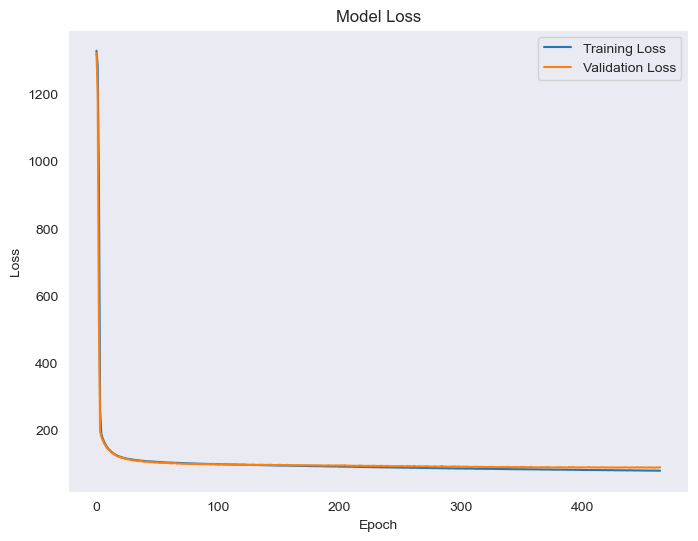

In [172]:
# plot the loss
utils.plot_loss(ann)

## Results

### XGBoost

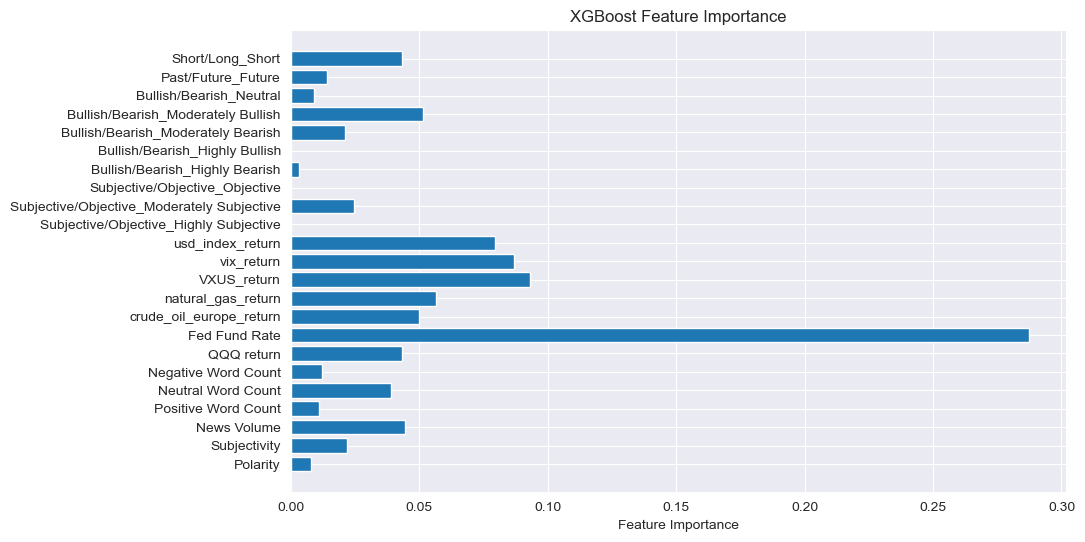

In [182]:
# create a feature importance chart for the XGBoost model
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, xgb_model.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

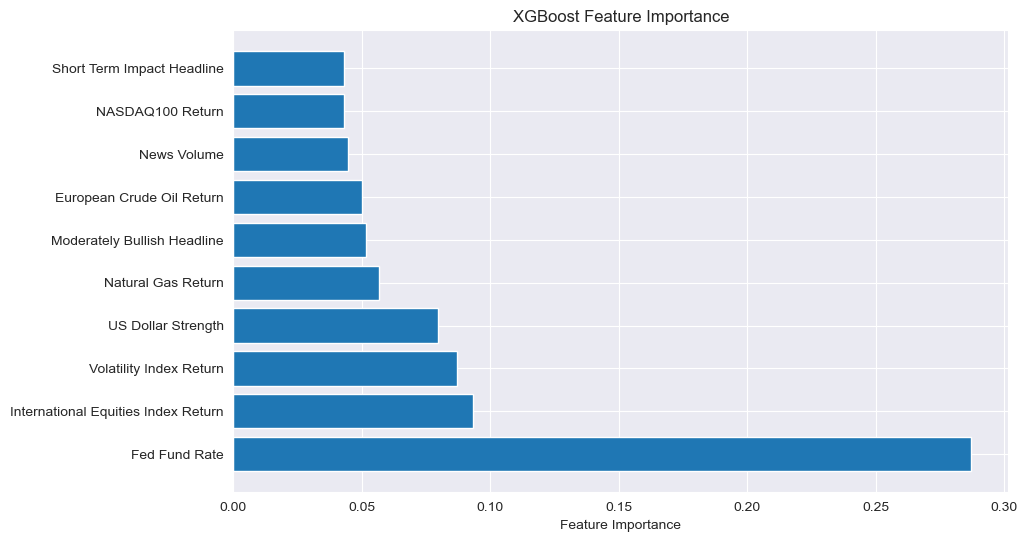

In [184]:
# show the top 10 features
feature_importance = pd.DataFrame(xgb_model.feature_importances_, index=X_train.columns, columns=['Importance'])
feature_importance.sort_values(by='Importance', ascending=False).head(10)

# change the names of the columns to the following:
names = {
    'Short/Long_Short': 'Short Term Impact Headline',
    'QQQ return': 'NASDAQ100 Return',
    'crude_oil_europe_return': 'European Crude Oil Return',
    'Bullish/Bearish_Moderately Bullish': 'Moderately Bullish Headline',
    'natural_gas_return': 'Natural Gas Return',
    'usd_index_return': 'US Dollar Strength',
    'vix_return': 'Volatility Index Return',
    'VXUS_return': 'International Equities Index Return',
    'Fed Funds Rate': 'Federal Funds Rate',
}

feature_importance = feature_importance.rename(index=names)
feature_importance.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance.sort_values(by='Importance', ascending=False).head(10).index,
         feature_importance.sort_values(by='Importance', ascending=False).head(10)['Importance'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

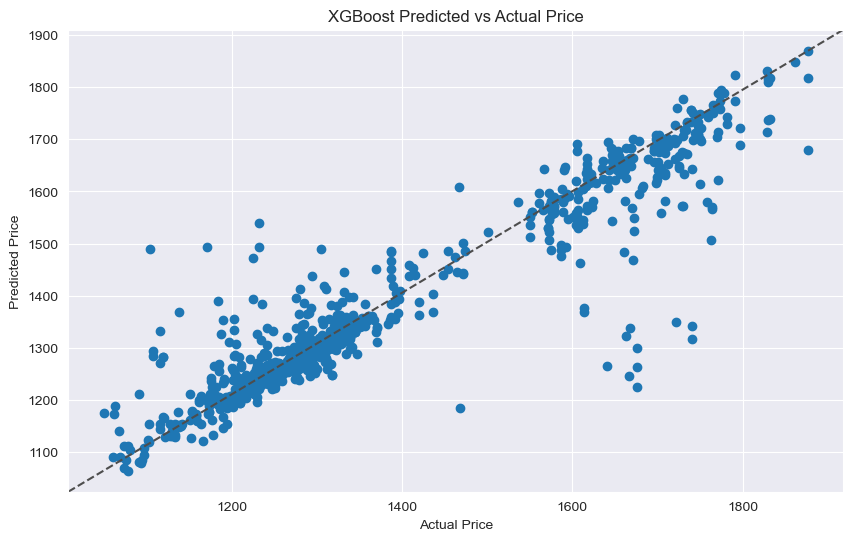

In [191]:
# create a predicted vs actual plt
plt.figure(figsize=(10, 6))
#add diagonal line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c=".3")
plt.scatter(y_test, y_pred_xgb_tuned)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('XGBoost Predicted vs Actual Price')
plt.show()

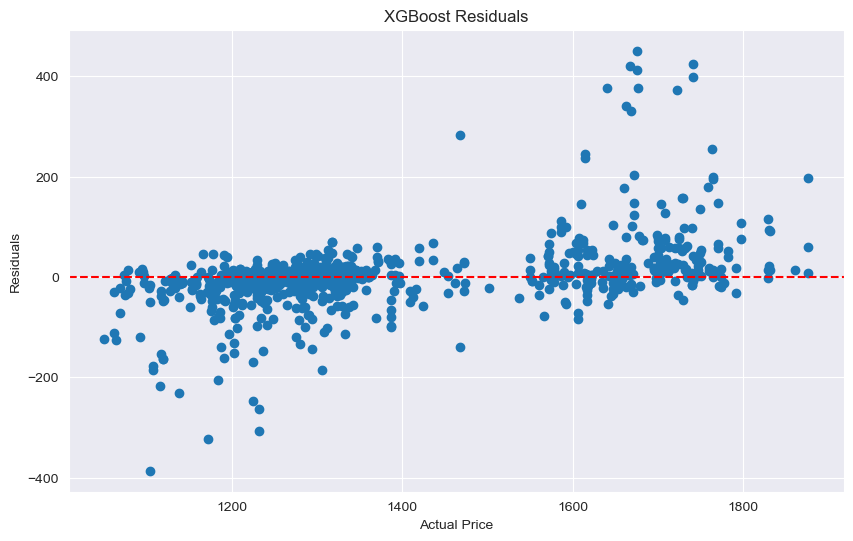

In [190]:
# create a residual plot
residuals = y_test - y_pred_xgb_tuned
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.title('XGBoost Residuals')
plt.show()

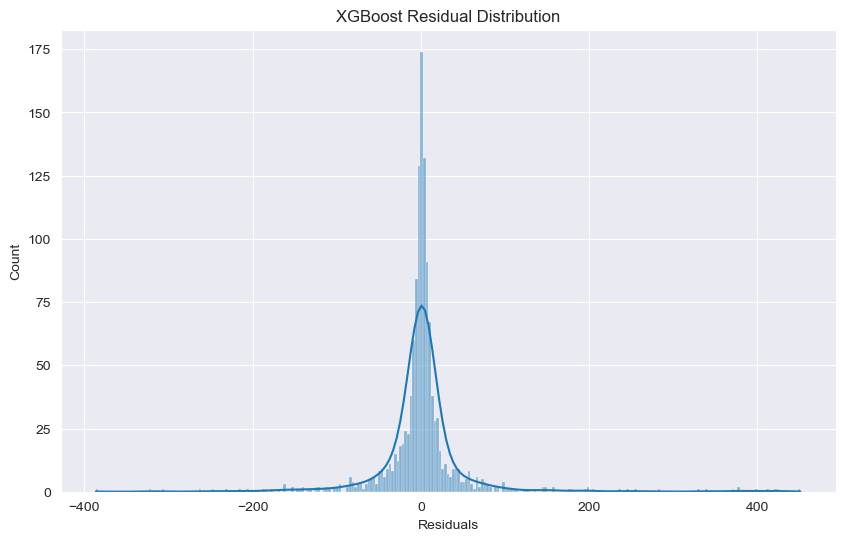

In [194]:
# create a residual distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('XGBoost Residual Distribution')
plt.show()

In [173]:
models = ['Linear Regression', 'Random Forest', 'AdaBoost', 'XGBoost', 'ANN']
predictions_base_train = [y_pred_lr_train, y_pred_rf_train, y_pred_ada_train, y_pred_xgb_train, y_pred_ann_train]
predictions_base_test = [y_pred_lr, y_pred_rf, y_pred_ada, y_pred_xgb, y_pred_ann]
predictions_tuned_train = [y_pred_lr_train, y_pred_rf_tuned_train, y_pred_ada_tuned_train, y_pred_xgb_tuned_train,
                           y_pred_ann_train]
predictions_tuned_test = [y_pred_lr, y_pred_rf_tuned, y_pred_ada_tuned, y_pred_xgb_tuned, y_pred_ann]

results = utils.evaluate_models(models=models, predictions_base_train=predictions_base_train,
                                predictions_base_test=predictions_base_test,
                                predictions_hyper_train=predictions_tuned_train,
                                predictions_hyper_test=predictions_tuned_test, X=X, y_train=y_train, y_test=y_test,
                                task='regression')
results

,,Linear Regression,Random Forest,AdaBoost,XGBoost,ANN,Best Model,Best Value
Metric,Type,,,,,,,
Mean Absolute Error,Train - Base,114.877646,11.306998,1.440243,10.505838,80.402885,AdaBoost,14.039906
Mean Squared Error,Train - Base,23526.762922,659.633013,20.726412,303.012458,15970.351335,AdaBoost,2786.720704
Root Mean Squared Error,Train - Base,153.384363,25.683322,4.552627,17.407253,126.373855,AdaBoost,52.789400
R-squared,Train - Base,0.183106,0.977096,0.99928,0.989479,0.445479,AdaBoost,0.907480
Adjusted R-squared,Train - Base,0.178927,0.976979,0.999277,0.989425,0.442642,AdaBoost,0.905557
Mean Absolute Error,Test - Base,113.807232,30.890744,14.039906,28.721772,89.903136,AdaBoost,14.039906
Mean Squared Error,Test - Base,23618.791325,5202.535477,2786.720704,3420.308397,17660.588585,AdaBoost,2786.720704
Root Mean Squared Error,Test - Base,153.684063,72.128604,52.7894,58.483403,132.893147,AdaBoost,52.789400
R-squared,Test - Base,0.215848,0.827274,0.90748,0.886445,0.413662,AdaBoost,0.907480
